## Example: (nonlinear) IV causal inference (with invalid IVs)
> Below is an example that demonstrates the usage of `ts_twas` in `nl_causal`.

## Simulate Data

- **library:** `nl_causal.base.sim`
- **Two Stage Datasets:** two independent datasets, **2SLS** and **2SIR** require different types of datasets:
  * For 2SLS:
    + Stage 1. LD matrix (`np.dot(Z1.T, Z1)`) + XZ_sum (`np.dot(Z1.T, X1)`)
    + Stage 2. ZY_sum (GWAS summary) (`np.dot(Z2.T, y2)`)
  * For 2SIR:
    + Stage 1. invidual-level data `Z1` and `X1`
    + Stage 2. ZY_sum (GWAS summary) (`np.dot(Z2.T, y2)`)
- **Remarks:** In terms of data, the advantage of 2SLS is merely requiring summary statistics of XZ and YZ in both Stages 1 and 2.

In [11]:
## import libraries
import numpy as np
from nl_causal.base import sim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## simulate a dataset
np.random.seed(1)
n, p = 2000, 50
beta0 = 0.10
theta0 = np.ones(p) / np.sqrt(p)
## simulate invalid IVs
alpha0 = np.zeros(p)
alpha0[:5] = 1.

Z, X, y, phi = sim(n, p, theta0, beta0, alpha0=alpha0, case='quad', feat='AP-normal')

## normalize the dataset
center = StandardScaler(with_std=False)
mean_X, mean_y = X.mean(), y.mean()
Z, X, y = center.fit_transform(Z), X - mean_X, y - mean_y

## Standard the y s.t. std(y), 
## this equal to / std(y) for both stage models.
y_scale = y.std()
y = y / y_scale
Z = Z / y_scale
phi = phi / y_scale

## generate two-stage dataset
Z1, Z2, X1, X2, y1, y2 = train_test_split(Z, X, y, test_size=0.5, random_state=42)
n1, n2 = len(Z1), len(Z2)
LD_Z1, cov_ZX1 = np.dot(Z1.T, Z1), np.dot(Z1.T, X1)
LD_Z2, cov_ZY2 = np.dot(Z2.T, Z2), np.dot(Z2.T, y2)

## Models
- **library:** `nl_causal.ts_models._2SLS` and `nl_causal.ts_models._2SIR`
- **Methods:** [2SLS](https://doi.org/10.1080/01621459.2014.994705) and [2SIR](https://openreview.net/pdf?id=cylRvJYxYI)
- **sparse regression:**
    + `sparse_reg=None`: assume all IVs are valid.
    + specify a sparse regression method from `sparse_reg` to detect invalid IVs, such as `SCAD`.
- **Remarks.** 2SIR circumvents the linearity assumption in the standard 2SLS, and includes 2SLS as a special case.

In [2]:
from nl_causal.ts_models import _2SLS, _2SIR

In [4]:
## 2SLS

# specify a sparse regression model to detect invalid IVs
from nl_causal.sparse_reg import L0_IC
Ks = range(int(p/2))
reg_model = L0_IC(fit_intercept=False, alphas=10**np.arange(-1,3,.3),
				  Ks=Ks, max_iter=10000, refit=False, find_best=False)
LS = _2SLS(sparse_reg=reg_model)

## Stage-1 fit theta
LS.fit_theta(LD_Z1, cov_ZX1)
## Stage-2 fit beta
LS.fit_beta(LD_Z2, cov_ZY2, n2)
LS.selection_summary().head(5)

,candidate_model,criteria,mse
0,[50],-0.108527,0.890979
1,"[3, 50]",-0.560189,0.563266
2,"[2, 50]",-0.629131,0.525741
3,"[1, 2, 50]",-0.828753,0.427639
4,"[2, 3, 50]",-0.864878,0.412466


In [5]:
## produce p_value and CI for beta
LS.test_effect(n2, LD_Z2, cov_ZY2)
LS.CI_beta(n1, n2, Z1, X1, LD_Z2, cov_ZY2)
LS.summary()

╔══════════════════════════════════════════╗
║ 2SLS                                     ║
║ ----                                     ║
║ x = z^T θ + ω;                           ║
║ y = β x + z^T α + ε.                     ║
║ ---                                      ║
║ β: causal effect from x to y.            ║
║ ---                                      ║
║ Est β (CI): 0.107 (CI: [0.0398 0.1733])  ║
║ p-value: 0.0017, -log10(p): 2.7611       ║
╚══════════════════════════════════════════╝


In [7]:
## 2SIR

Ks = range(int(p/2))
reg_model = L0_IC(fit_intercept=False, alphas=10**np.arange(-1,3,.3),
				  Ks=Ks, max_iter=10000, refit=False, find_best=False)

SIR = _2SIR(sparse_reg=reg_model)
## Stage-1 fit theta
SIR.fit_theta(Z1, X1)
## Stage-2 fit beta
SIR.fit_beta(LD_Z2, cov_ZY2, n2)
SIR.selection_summary().head(5)

,candidate_model,criteria,mse
0,[50],-0.109594,0.890029
1,"[3, 50]",-0.561034,0.562789
2,"[2, 50]",-0.633730,0.523329
3,"[1, 2, 50]",-0.832406,0.426080
4,"[2, 3, 50]",-0.868054,0.411158


In [8]:
## generate CI for beta
SIR.test_effect(n2, LD_Z2, cov_ZY2)
SIR.CI_beta(n1, n2, Z1, X1, LD_Z2, cov_ZY2)
SIR.summary()

╔══════════════════════════════════════════╗
║ 2SIR                                     ║
║ ----                                     ║
║ ψ(x) = z^T θ + ω;                        ║
║ y = β ψ(x) + z^T α + ε.                  ║
║ ---                                      ║
║ β: causal effect from x to y.            ║
║ ---                                      ║
║ Est β (CI): 0.110 (CI: [0.0438 0.1766])  ║
║ p-value: 0.0012, -log10(p): 2.9104       ║
╚══════════════════════════════════════════╝


## Inference Results

In the simulated data, the true causal effect is `beta0 = 0.10`.

- 2SLS provides wrong p-values and CIs, and fails to reject the null hypothesis that `H0: beta = 0`. 
- 2SIR provides a valid CI and reject the null hypothesis.

## Estimation the causal link  ψ(x)
- This is only feasible for **2SIR**.

In [13]:
## fit the causal link
SIR.fit_link(Z1=Z1, X1=X1)
# evalue ψ(x) based on the estimated causal link
est_phi = SIR.link(X[:,np.newaxis])

# since the model may change in constants, we first center the data
phi = phi - np.mean(phi)
est_phi = est_phi - np.mean(est_phi)

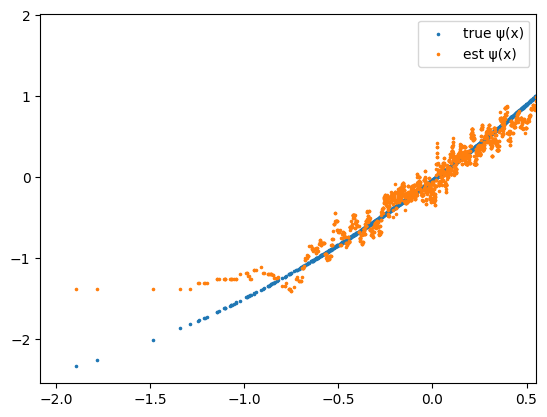

In [14]:
import matplotlib.pyplot as plt

plt.xlim(1.1*min(X), np.quantile(X,0.95))
plt.scatter(X, phi, s=2.5, label='true ψ(x)')
plt.scatter(X, est_phi, s=2.5, label='est ψ(x)')
plt.legend()
plt.show()

In [12]:
len(X)

2000